<a href="https://colab.research.google.com/github/mafaldasalomao/Segmenta-o-de-Imagens-com-Python-de-A-a-Z/blob/main/UNET_microscopics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Segmentação Semântica - Microscópicas
A segmentação semântica e a de instâncias tem sido usada amplamente no setor de Saúde durante a pandemia de COVID-19 para para ajudar os médicos a distinguir, entre as imagens de raios-X de vários pulmões, quais exibem pneumonia normal e quais exibem infecção por Coronavirus (há um paper interessante a respeito disso nesse link [aqui](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7605758/).

In [1]:
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow
import random
tensorflow.__version__

'2.9.2'

# Dataset

- **Data Science Bowl de 2018** - https://www.kaggle.com/c/data-science-bowl-2018

In [2]:
os.environ['RF_CPP_MIN_LOG_LEVEL']= '2' # hiden wanrings

In [3]:
os.environ['KAGGLE_USERNAME'] = 'gabevr'
os.environ['KAGGLE_KEY'] = 'ca479e66ac6ae221b62be68f056aca65'

In [4]:
!kaggle competitions download -c data-science-bowl-2018

 99% 356M/358M [00:10<00:00, 31.7MB/s]
100% 358M/358M [00:10<00:00, 36.9MB/s]


In [5]:
!unzip data-science-bowl-2018.zip


Archive:  data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   


In [6]:
!unzip stage1_train.zip -d /content/treinamento/
!unzip stage1_test.zip -d /content/teste/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d86ee01921b1c9ed23c342952253682060512483c39c8b7b5c6d8350f6df2568.png  
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/d8b76279ad8f2e101bb8c5ca95229b6532903eea035ef945dd4a21356d49dead.png  
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/dc05f946c096c5fcc147024843f21c06c3a94af25d4f37b498ea937953b806fe.png  
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e0fd1c4e98bb470bea315e7d8f74396450fe93e93f68e1f8a3443b2b397c8640.png  
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0/masks/e4b6643cafde8ac789b63f7b1a023773960dbe63489963985033619fde052dc9.png  
  inflating: /content/treinamento/d52958107d0b1f0288f50f346a8

In [7]:
img_altura = 256
img_largura = 256
canais = 3

In [8]:
seed = 42
np.random.seed = seed
random.seed = seed
path_treinamento = 'treinamento/'
path_teste = 'teste/'

In [9]:
train_ids = next(os.walk(path_treinamento))[1]
teste_ids = next(os.walk(path_teste))[1]

In [10]:
len(train_ids), len(teste_ids)

(670, 65)

In [11]:
dataset_img = np.zeros((len(train_ids), img_altura, img_largura, canais), dtype=np.uint8)
dataset_mask = np.zeros((len(train_ids), img_altura, img_largura, 1), dtype=np.bool)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [12]:
dataset_img.shape, dataset_mask.shape

((670, 256, 256, 3), (670, 256, 256, 1))

In [13]:
print('Redimensionando imagens e mascaras')

Redimensionando imagens e mascaras


In [14]:
for n, id_, in tqdm(enumerate(train_ids), total=len(train_ids)):
  path = path_treinamento + id_
  print(path)
  if "." in path:
    continue
  img = cv2.imread(path + '/images/' + id_ + '.png')[:, :, :canais] #ler imagens
  img = cv2.resize(img, (img_altura, img_largura)) # redimensionar
  dataset_img[n] = img
  mask = np.zeros((img_altura, img_largura, 1), dtype=np.bool) #empty mask (0)
  for mask_file in next(os.walk(path +'/masks/'))[2]:
    mask_ = cv2.imread(path+'/masks/'+mask_file)
    mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY)
    mask_ = np.expand_dims(cv2.resize(mask_, (img_altura, img_largura)), axis=-1)
    mask = np.maximum(mask, mask_)
  
  dataset_mask[n] = mask

  0%|          | 0/670 [00:00<?, ?it/s]

treinamento/28d33efef218392e79e385906deb88055d94b65ad217de78c07e85476f80f45a


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':
  0%|          | 2/670 [00:00<00:34, 19.39it/s]

treinamento/3b0709483b1e86449cc355bb797e841117ba178c6ae1ed955384f4da6486aa20
treinamento/62570c4ff1c5ab6d9d383aba9f25e604768520b4266afd40fdf4734a694c8bc3
treinamento/b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229
treinamento/b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38


  2%|▏         | 11/670 [00:00<00:22, 28.69it/s]

treinamento/3874755f6222e83006fdad4d664ec0d9697c13af4fbe24b2f9a059bb13075186
treinamento/fadeb0ab092833f27daaeb3e24223eb090f9536b83f68cde8f49df7c544f711b
treinamento/f534b43bf37ff946a310a0f08315d76c3fb3394681cf523acef7c0682240072a
treinamento/4185b9369fc8bdcc7e7c68f2129b9a7442237cd0f836a4b6d13ef64bf0ef572a
treinamento/a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7
treinamento/88d5a03f8ecd459f076a06e0d5035149193bfdd727c30905de19054dcb9018ae
treinamento/10328b822b836e67b547b4144e0b7eb43747c114ce4cacd8b540648892945b00
treinamento/0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e
treinamento/3b957237bc1e09740b58a414282393d3a91dde996b061e7061f4198fb03dab2e
treinamento/dbe5ad05b6f87018159a3228c1d1725892a1bfb9fa9f8fcc2e8bfe70d69d0355
treinamento/f0c9f135c62572f3669a75b2c735e4477dc77fac85e653426ee2b3bcfbed7aaf
treinamento/9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e


  3%|▎         | 23/670 [00:00<00:18, 35.88it/s]

treinamento/6bc8cda54f5b66a2a27d962ac219f8075bf7cc43b87ba0c9e776404370429e80
treinamento/34c9f4eb2af8b8f46b1d88b74bde16f4614cd08948c2f1d817eb629afc512e7a
treinamento/4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06
treinamento/8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1
treinamento/72b18a405555ad491721e29454e5cd325055ce81a9e78524b56f2c058a4d2327
treinamento/64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa116c0d0ea56b1322f806f0b9
treinamento/3b3f516ebc9a16cff287a5ffd3a1861a345a6d38bedbba74f1c0b0e0eac62afd
treinamento/2869fad54664677e81bacbf00c2256e89a7b90b69d9688c9342e2c736ff5421c
treinamento/815524d88283ba10ad597b87aa1967671db776df8004a0c4291b67fc2624c22a
treinamento/9cbc0700317361236a9fca2eb1f8f79e3a7da17b1970c179cf453921a6136001
treinamento/751f421d322940d6efe3bd570a66ecda16d08a1b90bc32a6d7ae1af89856fd49


  4%|▍         | 30/670 [00:00<00:14, 43.60it/s]

treinamento/1d5f4717e179a03675a5aac3fc1c862fb442ddc3e373923016fd6b1430da889b
treinamento/30f65741053db713b3f328d31d3234b6fedbe31df65c1a8ea29be28146cab789
treinamento/f728de04267283f0b4daab9a840e7433b2c6034baf195fd526850439c9297687
treinamento/33d0a9b24c25852ce35274b4b1777484ccd21f44dbe35491cc926e5948c1ce3e
treinamento/5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed


  6%|▌         | 39/670 [00:01<00:25, 24.43it/s]

treinamento/7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2
treinamento/da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920
treinamento/516a0e20327d6dfcedcf57e3056115e4fb29cdf4cb349003bdfc75c9b7f5c2cf
treinamento/b909aa8f6f4bec37c3fb6ff5a85d166162d07983506fcc57be742b0f9dbafbf7
treinamento/7f55678298adb736987d9fb5d1d2daefb08fe5bf4d81b2380bedf9449f79cc38
treinamento/243443ae303cc09cfbea85bfd22b0c4f026342f3dfc3aa1076f27867910d025b
treinamento/45c3bdef1819ba7029990e159f61543ed25781d13fb4dc5d4de52e803debd7d3
treinamento/d751ccb64fa767a65a966061218438bd1860695d96bbef11fdb2f0d3b8dedba8
treinamento/d7db360fabfce9828559a21f6bffff589ae868e0dc6101d7c1212de34a25e3cb
treinamento/76faaed50ed6ea6814ac36199964b86fb09ba7f41a6f213bceaa80d625adc2e1


  7%|▋         | 48/670 [00:01<00:27, 22.65it/s]

treinamento/92e7e86e765e05ce331c07a6d14f0a696eac7ee40058699243900f40b696d7aa
treinamento/4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94
treinamento/d4d6c683f249d82518431603bf0206d05f2114ac871a99ffade0f5f61cf167e1
treinamento/4948e3dfe0483c2198b9616612071ead5474dffd223071cf0a567aea9aca0b9e
treinamento/564fa390d9a9c26f986bf860d9091cbd84244bc1c8e3c9369f2f2e5b5fd99b92
treinamento/7978812d0e2e034ee1f9c141f019705582fcaa290e4a01c6c75a62753285cb23
treinamento/f9ac03b0344ce8c48bc058448541f9211a1e5f4c94fdaf633dd534328d8610ab
treinamento/8d29c5a03e0560c8f9338e8eb7bccf47930149c8173f9ba4b9279fb87d86cf6d
treinamento/212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6


  8%|▊         | 52/670 [00:02<00:35, 17.21it/s]

treinamento/d910b2b1be8406caecfe31a503d412ffc4e3d488286242ebc7381836121dd4ef
treinamento/c75139ef0546d2240b37afb3219eb74a06b7977818697d5c3138796472483af3
treinamento/1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e


  8%|▊         | 55/670 [00:02<00:43, 14.13it/s]

treinamento/e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243


  9%|▊         | 58/670 [00:03<00:50, 12.07it/s]

treinamento/d7ec8003735996458b56ccb8ae34d080eb2a6adabef931323239632515b4b220
treinamento/0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c
treinamento/af6b6173c59450bc76b2cc461cf233921fbfdb6feb8dd6da03a0d44193221fd0
treinamento/4ff152d76db095f75c664dd48e41e8c9953fd0e784535883916383165e28a08e
treinamento/7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317


  9%|▉         | 61/670 [00:03<00:51, 11.75it/s]

treinamento/608ff81c8a0c8b622f6648a9c7f935d85f0c503f515ef2ac3728387be1953ee8
treinamento/3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd
treinamento/958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f


 10%|▉         | 64/670 [00:03<00:57, 10.53it/s]

treinamento/8e8a7a14749d0b2e48de3d10e2e80063f17b165ad921c8afc0623f08500f3259
treinamento/a7f6194ddbeaefb1da571226a97785d09ccafc5893ce3c77078d2040bccfcb77
treinamento/351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c


 10%|█         | 67/670 [00:03<00:59, 10.15it/s]

treinamento/fc5452f612a0f972fe55cc677055ede662af6723b5c1615ad539b8a4bd279bdb
treinamento/b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac


 10%|█         | 69/670 [00:04<01:07,  8.86it/s]

treinamento/b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db
treinamento/3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe
treinamento/8ecdb93582b2d5270457b36651b62776256ade3aaa2d7432ae65c14f07432d49
treinamento/8aa1a883f61f0bb5af3d3d60acaaf33af45ef4fbffaac15ae838bc1ce37b6fbf
treinamento/fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de


 11%|█         | 74/670 [00:04<00:51, 11.62it/s]

treinamento/27c30f9011492f234e4587c9a4b53c787037d486f658821196fe354240ac3c47
treinamento/da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844


 12%|█▏        | 82/670 [00:05<00:38, 15.14it/s]

treinamento/4bf6a5ec42032bb8dbbb10d25fdc5211b2fe1ce44b6e577ef89dbda17697d819
treinamento/ce37f6dd0615d45e66e41a8f2ed6fbc0bbe3103a290394ad474207507710eacc
treinamento/5b2ccfb94dedf2ec8797c0404fc324888e35ab903c41bb26f070552033ca8e6c
treinamento/e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c
treinamento/1e488c42eb1a54a3e8412b1f12cde530f950f238d71078f2ede6a85a02168e1f
treinamento/602f267432e7a573e1092f1cf48135c82d0fbc8722bc028b9330ec801a40bb18
treinamento/abbfff07379bceb69dba41dad8b0db5eb80cc8baf3d4af87b7ee20b0dac32215
treinamento/139946af9e2c7ef4f0298e622b831dbef5e5c0cd088eb5bc3382f8df9355443d
treinamento/8d9b4205ddb10fa49a2973b4f3a2dc6923407ae015081e1a52c4b4c2fe8faa53
treinamento/b2c5d8653c621207e97b699e5c4c05d13df4f02d9db3e594b1f0c22e5b746aae
treinamento/20e209f6ffa120a72712e1b4c1d3e24d1339227e2936abd4bbd49a636fada423


 13%|█▎        | 87/670 [00:05<00:30, 19.34it/s]

treinamento/4c465a54e329ec7b0f4bc5f6acdfd3192707d6c0fbdf557339485581c5a6b3c1
treinamento/305a8baaf726d7c9e695bff31d3a6a61445999a4732f0a3e6174dc9dcbe43931
treinamento/1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5


 14%|█▍        | 93/670 [00:05<00:33, 17.20it/s]

treinamento/cbff60361ded0570e5d50429a1aa51d81471819bc9b38359f03cfef76de0038c
treinamento/8a65e41c630d85c0004ce1772ff66fbc87aca34cb165f695255b39343fcfc832
treinamento/b24ea5c268469a95ed155eeaf809e36030b78a2eb530a0cb2380cdc1ccdb7dd1
treinamento/7aae06bc4558829473071defec0b7ab3bfa9c5005548a13da95596bb6a66d105


 14%|█▍        | 96/670 [00:05<00:29, 19.36it/s]

treinamento/33618678c167c5e07be02c49d0c43bcd90493ba5d83110a631409a4d3ccc1e51
treinamento/c7d546766518703580f63d5d8f11d54971044753f53c0b257d19c2f99d4bfdd0
treinamento/3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0


 15%|█▍        | 99/670 [00:06<00:39, 14.58it/s]

treinamento/af8621ef0db8c26b0bce6385bd5609b584bfd678fcf7a234b8a15e6bb05c15ac
treinamento/a22b7882fa85b9f0fcef659a7b82bfcddf01710f9a7617a9e036e84ac6901841
treinamento/7ba20aa731cc21af74a8d940254176cbad1bdc44f240b550341c6d9c27509daa
treinamento/c35e6e3ea39a718e1b7aff66e4cc678efd662f9b5336b74d69c1d6bca7aaf288
treinamento/ea94ba4b01d1bd5f7768d10e0ac547743791033df545c71fcec442d0cb5cb5e7
treinamento/76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450


 15%|█▌        | 103/670 [00:06<00:44, 12.61it/s]

treinamento/b82548ab19466b461614e6055aaf49fbc24c03a2d20e65575b680c7c28268807
treinamento/9c95eae11da041189e84cda20bdfb75716a6594684de4b6ce12a9aaadbb874c9
treinamento/55ff2b0ec48b76e10c7ee18add5794005cd551697f96af865c763d50da78dd9c
treinamento/8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842


 17%|█▋        | 112/670 [00:07<00:51, 10.88it/s]

treinamento/5bda829acd824821bc1f3f6573cf065d364653d5322f033a4af943f7a6170566
treinamento/e49fc2b4f1f39d481a6525225ab3f688be5c87f56884456ad54c953315efae83
treinamento/57bd029b19c1b382bef9db3ac14f13ea85e36a6053b92e46caedee95c05847ab
treinamento/8f6597cd978c060378177df76e554d0578b97eab471e237dbe0adc0dd0d93d63
treinamento/03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe
treinamento/813f41ef376c3cbcc9d6e2ce6a51c2ee068226d1c1b13404eb238dcfdd447c97
treinamento/c322c72b9d411e631580fee9312885088b4bb14ed297aa4b246ec943533b3ffb
treinamento/e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b
treinamento/b67a6e5da8b1cfa5319d94a7d3f8b706725753346c37a4636bf7382e98b3c5df
treinamento/92f31f591929a30e4309ab75185c96ff4314ce0a7ead2ed2c2171897ad1da0c7
treinamento/f43169e3d8b4f71e687945b9e72cbfdfe2e40e68842568e6a30c60d64c1378b6
treinamento/c96109cbebcf206f20035cbde414e43872074eee8d839ba214feed9cd36277a1
treinamento/f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1

 19%|█▊        | 124/670 [00:07<00:27, 20.10it/s]

treinamento/37ed50eea5a1e0bade3e6753793b6caeb061cd4c2f365658c257f69cab1f6288
treinamento/003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1
treinamento/9586e48a9a4353f11898a6a4b7475a91574e8af82e99c4b7a5e1f1b18f345f7a
treinamento/ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee
treinamento/1f0008060150b5b93084ae2e4dabd160ab80a95ce8071a321b80ec4e33b58aca
treinamento/e5a7b8a9924b26b3abf039255a8a3bb00258f4966f68ff3349560b4350af9367
treinamento/317832f90f02c5e916b2ac0f3bcb8da9928d8e400b747b2c68e544e56adacf6b
treinamento/930f246a8e4ff273a72a6e4b3cf8e8caff94fca4eaf1dbe6f93ba37b8195c0a0


 20%|█▉        | 132/670 [00:08<00:24, 22.35it/s]

treinamento/3ca8181367fc1258a418f7bf5044533c83e02a59c1a96def043295c429c297a8
treinamento/9520aff4efe87bd8f3901652fa2dde9b4bc9c679325966145ce00c1ca33f35de
treinamento/2dec81a678ddcac2b110acffe82427d857695180bd841e3f9736a554acf832af
treinamento/2349e95ece2857c89db7e4a8be8c88af0b45f3c4262608120cb3bd6ef51fd241
treinamento/bff985591dd5d6303018a6e9a3dcfb336771a414ad4605c24ce1c1155fc86a96
treinamento/e5384c905e9879cb6e8ff5250fb03155bc1db035d8dde458eece9078b7de8ff1
treinamento/56d0da5b663ddd49955478c00ca03118c367ff7dd6a646b8c875b0acb207d1c5
treinamento/b0d6dfcc95e4d087d232378f860fc3ef9f95ea5a4c26d623a0be091f820a793f
treinamento/c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932


 22%|██▏       | 146/670 [00:08<00:23, 21.91it/s]

treinamento/2b50b1e3fa5c5aa39bc84ebfaea9961b7199c4d2488ae0b48d0b3459807d59d2
treinamento/5d75a63972ef643efd7c42f20668b167f2af43635d6263962d84e62e7609ab51
treinamento/9ebcfaf2322932d464f15b5662cae4d669b2d785b8299556d73fffcae8365d32
treinamento/947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050
treinamento/0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9
treinamento/3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9
treinamento/98c5ead89cd066637efd5c93a6edc55c85908eb66807471f0d246d5457341f9c
treinamento/5419302571113e9aa74c7c0a9575333ca539b871a16c86ee92b35170b4ddc52e
treinamento/b7a86f4968071e0f963fa87ef314fdd1b6c73a66355431cc53a37e193ba6be9b
treinamento/0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2


 22%|██▏       | 150/670 [00:09<00:21, 23.76it/s]

treinamento/20c37b1ad2f510ed7396969e855fe93d0d05611738f6e706e8ca1d1aed3ded45
treinamento/6ab24e7e1f6c9fdd371c5edae1bbb20abeeb976811f8ab2375880b4483860f4d
treinamento/072ff14c1d3245bf49ad6f1d4c71cdb18f1cb78a8e06fd2f53767e28f727cb81
treinamento/a7f767ca9770b160f234780e172aeb35a50830ba10dc49c526f4712451abe1d2
treinamento/e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2


 23%|██▎       | 154/670 [00:09<00:35, 14.36it/s]

treinamento/bbce7ebc40323a0eff6574d0c3842f50f907f55fbfb46c777f0ed9a49e98ff9b
treinamento/8055957570d7b38f0acecdb56f3078a963a1a7307ca03fcca62212e0e95e5845
treinamento/866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855
treinamento/03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a
treinamento/718751b439c05bdd589f04fcef321a86be3ecb35292a435138e295e05eb2e771
treinamento/84e642d75ae6ece8147272418b6fe13d04db8d076fe306c4acedc329fceab564
treinamento/1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df


 24%|██▍       | 164/670 [00:10<00:33, 14.97it/s]

treinamento/9facc652efe19f634639585d692a53dd6c2a8e2f0c9baebdfd85b9b41ec58851
treinamento/a0de55384fada5cbc46bd7a41f6feeef93b67d088497c7316079ccec39c2a834
treinamento/a022908f1b7880838dbc0411e50828e64b4f5e0263afdf04295e30bb2ff58005
treinamento/853a4c67900c411abd04467f7bc7813d3c58a5f565c8b0807e13c6e6dea21344
treinamento/ed5be4b63e9506ad64660dd92a098ffcc0325195298c13c815a73773f1efc279
treinamento/08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992


 25%|██▍       | 167/670 [00:10<00:47, 10.58it/s]

treinamento/3852c7e45bd885b9537e276861ab50b99bb42f0f8e717d2f88174c62862ca3ff
treinamento/c89ac06daef5c819309f03d6a35792d1a8a66abb8cb3414013ffe71d3dd9fe96
treinamento/150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f


 25%|██▌       | 170/670 [00:11<00:54,  9.17it/s]

treinamento/97158b2fe38783d88d4e44ba1b7bc6c84f225f8b35fcccc2f9265c65f14e7c8b
treinamento/08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada
treinamento/3a508d2dc03db46e7f97a2a30eabb62ab2886f3cedfea303de8f6a42e50d20eb
treinamento/dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05


 27%|██▋       | 178/670 [00:11<00:37, 13.08it/s]

treinamento/d7fc0d0a7339211f2433829c6553b762e2b9ef82cfe218d58ecae6643fa8e9c7
treinamento/d827a7d80fc67487a3237135e0d43ae01b7bbcb135e1a167601fc974a8348c51
treinamento/f7e5dcfc9c93183c668c5a4ab028d5faad54fb54298711f2caae0508aa978300
treinamento/76c44d1addac92a65f1331f2d93f4e3b130bd4e538a6e5239c3ac1f4c403608a
treinamento/c3bec1066aae20f48b82975e7e8b684cd67635a8baf211e4d9e3e13bc54c5d06
treinamento/0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426
treinamento/2abc40c118bc7303592c8bb95a80361e27560854b8971ab34dcf91966575b1f2
treinamento/e81c758e1ca177b0942ecad62cf8d321ffc315376135bcbed3df932a6e5b40c0
treinamento/7af09f98ec299ba0658d759eebc4c34e1c98289ea6ce37f233e9f5e4e2fc84f4
treinamento/54fe2d3416951cbc48f8718624c86a7ae58b6022a7fa75591b13f625cf53658b


 28%|██▊       | 188/670 [00:12<00:23, 20.93it/s]

treinamento/21408476af0506331e8b5d49b385833e5ef1fbb90815fbf9af9d19b4bb145f76
treinamento/79fe419488ba98494e3baa35c6fef9662eda1efe325d0ab0ac002f5383245d96
treinamento/4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16ebf46babe4656a794e
treinamento/0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed
treinamento/c0c4a829c8d33d16a02f5dc0411597329f4b4d726ed6a22b5530cf6c8e106c4e
treinamento/ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6
treinamento/df5cdd0ebe1bdf8dc870bc294b8f08961e083bc7f9be69e268454aa9091808b9


 29%|██▊       | 192/670 [00:12<00:20, 23.30it/s]

treinamento/3441821ebea04face181c9e2f4d0d09727c764827ac51b9e7fbadbebabeab225
treinamento/55f98f43c152aa0dc8bea513f8ba558cc57494b81ae4ee816977816e79629c50
treinamento/4d40de30a3db3bc4f241cb7f48e8497c11e8f20a99bf55788bdce17242029745
treinamento/fe80a2cf3c93dafad8c364fdd1646b0ba4db056cdb7bdb81474f957064812bba
treinamento/1400420310c9094361a8a243545187f1d4c2365e081b3bb08c5fa29c7491a55b
treinamento/a1f50f101bc471e2d6967ebdb8ba81150588609e769f3b960f0801e4da5fdc6f
treinamento/12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40


 29%|██▉       | 196/670 [00:12<00:27, 17.27it/s]

treinamento/5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d
treinamento/c0152b1a260e71f9823d17f4fbb4bf7020d5dce62b4a12b3099c1c8e52a1c43a
treinamento/b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895


 32%|███▏      | 212/670 [00:13<00:23, 19.71it/s]

treinamento/d3ce382f190ee24729bd2e80684c11bef72bc9c733cdbbc19a17d2c1b2e775f7
treinamento/11a0170f44e3ab4a8d669ae8ea9546d3a32ebfe6486d9066e5648d30b4e1cb69
treinamento/4829177d0b36abdd92c4ef0c7834cbc49f95232076bdd7e828f1f7cbb5ed80ec
treinamento/aa58ba4512955771b4f9b459cb4e6a8adb71d11cd6cae662ec2df31d688a5fe0
treinamento/75120baa6abcbfe750a4eb223b8c10ae6bc3bebdda7b00d9a78bc2472fa28625
treinamento/4ca5081854df7bbcaa4934fcf34318f82733a0f8c05b942c2265eea75419d62f
treinamento/a815a986800a95de0957116c6585deea8ffb6ee09ad00ccc687306937ac698d0
treinamento/670ebd9d674be236b9bf0b28650ad3f68e1891b06e16a9021fd069ca7ef32b78
treinamento/d1ba6089cae2f90cb7275ece10ca393c25f60ea17e5c9c3cea2399d31fd41869
treinamento/b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39ff843884d84f61dee1
treinamento/0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6
treinamento/e66a97b2c77f3d66a7d3cebbc6a36c8c6259368a397f7b67647ed80ad53aa776
treinamento/66612c188d73e931e1863af2c99d2af782c32f65fd97d224abb40bbadb87263f

 33%|███▎      | 223/670 [00:15<00:48,  9.25it/s]

treinamento/449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b
treinamento/afa272dc01825d4b929b3bfc79a10f68dd3c163c450d858b964d1ce0bc93e131
treinamento/1e8408fbb1619e7a0bcdd0bcd21fae57e7cb1f297d4c79787a9d0f5695d77073
treinamento/c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb
treinamento/feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398
treinamento/1db1cddf28e305c9478519cfac144eee2242183fe59061f1f15487e925e8f5b5
treinamento/1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b
treinamento/50a7ea80dd73232a17f98b5c83f62ec89989e892fe25b79b36f99b3872a7d182
treinamento/1d4a5e729bb96b08370789cad0791f6e52ce0ffe1fcc97a04046420b43c851dd
treinamento/e856511ac1c34d24320eb7c56c05a4a3340d06667b4f5b8e8df615d415c7f650
treinamento/53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc


 34%|███▍      | 227/670 [00:16<00:45,  9.75it/s]

treinamento/af576e8ec3a8d0b57eb6a311299e9e4fd2047970d3dd9d6f52e54ea6a91109da
treinamento/bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d


 34%|███▍      | 230/670 [00:16<00:44,  9.88it/s]

treinamento/ae570a676961482848b5097038ef5e407df7a66a8e1c9b0567da599565a6b142
treinamento/1b2bf5933b0fb82918d278983bee66e9532b53807c3638efd9af66d20a2bae88
treinamento/07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5


 36%|███▌      | 238/670 [00:17<00:41, 10.52it/s]

treinamento/b6c9b58de0388891221b8f7a83cbf0b8f8379b51b5c9a127bf43a4fc49f1cc48
treinamento/c9f305be17312bdb9530fb4f1adc6d29730ddbe0e74730cbf031de174bf437b7
treinamento/f9ea1a1159c33f39bbe5f18bb278d961188b40508277eab7c0b4b91219b37b5d
treinamento/573e1480b500c395f8d3f1800e1998bf553af0d3d43039333d33cf37d08f64e5
treinamento/0d3640c1f1b80f24e94cc9a5f3e1d9e8db7bf6af7d4aba920265f46cadc25e37
treinamento/a31deaf0ac279d5f34fb2eca80cc2abce6ef30bd64e7aca40efe4b2ba8e9ad3d
treinamento/a08166d91d2cca263d2dd52764dc25c9c582b7a5ece2b802749fa4be33187c49
treinamento/4c032609d377bd980e01f888e0b298600bf8af0e33c4271a1f3aaf76964dce06


 36%|███▋      | 243/670 [00:17<00:30, 13.95it/s]

treinamento/16c3d5935ba94b720becc24b7a05741c26149e221e3401924080f41e2f891368
treinamento/04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e
treinamento/70827e40a7155391984e56703c6df3392fb4a94bbd6c7008da6a6ca3244965d9
treinamento/ef3ef194e5657fda708ecbd3eb6530286ed2ba23c88efb9f1715298975c73548
treinamento/40bcdad218ac5f0885fc247d88fcad9f729f55c81c79d241a8f1559b6d8c0574
treinamento/a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d


 37%|███▋      | 246/670 [00:17<00:36, 11.52it/s]

treinamento/13f2bec0a24c70345372febb14c4352877b1b6c1b01896246048e83c345c0914
treinamento/da8ca06ccbb4e2a8718f7c2939ef6cc3a4088981f660842ad885a8273e740d55
treinamento/2255d5aba044256bb92f6b7cbed0fca46d972c7b6b1a59dcbe7f682c5777d074
treinamento/6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699


 37%|███▋      | 250/670 [00:18<00:48,  8.59it/s]

treinamento/c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72
treinamento/2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812


 38%|███▊      | 257/670 [00:19<00:48,  8.55it/s]

treinamento/b98681c74842c4058bd2f88b06063731c26a90da083b1ef348e0ec734c58752b
treinamento/4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee2489c59e25ddd45e7a32
treinamento/df33b11184427e05c8a450f921586685975fe975f57315e686a0f26fddb93db1
treinamento/0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf577ec3c6f9c70c0cd1e
treinamento/ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d19659189951f540f48
treinamento/cab4875269f44a701c5e58190a1d2f6fcb577ea79d842522dcab20ccb39b7ad2
treinamento/fc9269fb2e651cd4a32b65ae164f79b0a2ea823e0a83508c85d7985a6bed43cf
treinamento/b0defa611b75645c0283464ee4163917bad382d335b61e8509f065bf371fa15f
treinamento/f20eb4592e7d3cf58d421a9c34832d33adcdcbd0e17b7bf009a013847608da27
treinamento/b560dba92fbf2af785739efced50d5866c86dc4dada9be3832138bef4c3524d2
treinamento/f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81


 40%|████      | 271/670 [00:20<00:31, 12.67it/s]

treinamento/bf4a61bb81589c9a67e3343408befd3e135af5e88b50c17f998f2131d24bc271
treinamento/e5f8ad0f0a43af8ca57e31e16800108abdfb44a7e962a71d246f72d2dbde42bf
treinamento/b6d50fa22380ae3a7e8c52c5bc44a254e7b2596fd8927980dbe2c160cb5689b5
treinamento/e66f25e175abab08ecb4e5f6859db64a211e0ddffb262d7e727b9d9bd4aad2d2
treinamento/6af82abb29539000be4696884fc822d3cafcb2105906dc7582c92dccad8948c5
treinamento/b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c
treinamento/1631352dbafb8a90f11219fffd3bea368a30bc3bad3bbe0e84e19bd720df4945
treinamento/0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0
treinamento/44ab6a09eedee848b072ea3acd0f4e781f9c43b8d4e3d62598e1024584bf0b01
treinamento/bb481eae02085bbae08742f702b9ab7d8b2ff9df2fbefeee9fac51f7c77dd01f
treinamento/8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b
treinamento/0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3
treinamento/6fc83b33896f58a4a067d8fdcf51f15d4ae9be05d8c3815d23336f1f2a8c45a1

 41%|████      | 276/670 [00:20<00:24, 15.79it/s]

treinamento/5c6eb9a47852754d4e45eceb9a696c64c7cfe304afc5ea491cdfef11d55c17f3
treinamento/b3bfd873fca7ff9b2e90f507dfdbe165bb8c153399b6ba5829aa59bae677a91d
treinamento/2c840a94d216f5ef4e499b53ae885e9b022cbf639e004ec788436093837823b2
treinamento/54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12


 42%|████▏     | 283/670 [00:21<00:28, 13.53it/s]

treinamento/49edc2f7715100fb0390916e52b3fd11a921f02e59509dc987f67840a36250fc
treinamento/abd8dde78f8d37b68b28da67459371ed65f0a575523e94bc4ecbc88e6fedf0d0
treinamento/ddf1bf458312de2895dd9cc5ce7ec9d334ad54c35edc96ad6001d20b1d8588d8
treinamento/a3a1b8f9794ef589b71faa9f35fd97ad6761c4488718fbcf766e95e31afa8606
treinamento/7b38c9173ebe69b4c6ba7e703c0c27f39305d9b2910f46405993d2ea7a963b80
treinamento/6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622


 43%|████▎     | 290/670 [00:21<00:27, 13.66it/s]

treinamento/7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072
treinamento/dbbfe08a52688d0ac8de9161cbb17cb201e3991aacab8ab8a77fe0e203a69481
treinamento/2f929b067a59f88530b6bfa6f6889bc3a38adf88d594895973d1c8b2549fd93d
treinamento/f4faa3a409014db1865074c5f66a0255f71ae3faba03265da0b3b91f68e8a8f0
treinamento/5953af5080d981b554529971903d8bee9871457a4361b51f04ba04f43793dd8f
treinamento/a0325cb7aa59e9c0a75e64ba26855d8032c46161aa4bca0c01bac5e4a836485e
treinamento/89be66f88612aae541f5843abcd9c015832b5d6c54a28103b3019f7f38df8a6d
treinamento/693bc64581275f04fc456da74f031d583733360a1f6032fa38b3fbf592ff4352
treinamento/2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707


 45%|████▌     | 302/670 [00:22<00:14, 24.65it/s]

treinamento/5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233
treinamento/f6cb37ebf29c225284c8415962f7287abe7007fae8fe3d8a3899b608b832d7d5
treinamento/f7eaaf420b5204c4a42577428b7cd897a53ef07b759ccbba3ed30a3548ca5605
treinamento/ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72
treinamento/06350c7cc618be442c15706db7a68e91f313758d224de4608f9b960106d4f9ca
treinamento/9b25b8ffd5f52b6c3d235a42d51d380503d1f80b61ef0f62eeb696f5977c38e6
treinamento/2c83c86dd4e5dacc024b55629375567fb8e320a82ef86f541cfe54764040fc25
treinamento/6bd330234b763b77796d4804de8e224881c0fc8dd02650fa708b2edfd8c7461f
treinamento/57b49733c5a3c268b013553635a826e6a1b10e699bbd19c3b842375fe0adf344
treinamento/2dd9d8c797fc695665326fc8fd0eb5cd292139fa478ccb5acb7fb352f7030063
treinamento/7f4d7b549d0f1a110191e2aded872943d85892bc30667f19fe9de97a5370b08e
treinamento/8f27ebc74164eddfe989a98a754dcf5a9c85ef599a1321de24bcf097df1814ca


 46%|████▌     | 308/670 [00:22<00:11, 30.31it/s]

treinamento/a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9c4d7b7428cfcb2eda4
treinamento/4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381


 47%|████▋     | 317/670 [00:23<00:20, 17.03it/s]

treinamento/6c85029f850d392791e13f74963391054ff54e508967bbd091ee510e9e58e011
treinamento/fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4b6bd267241e8a0787c
treinamento/a6515d73077866808ad4cb837ecdac33612527b8a1041e82135e40fce2bb9380
treinamento/7773ac91af61ed041701b7c3b649598e3707cf04c0577f464fd31be687f538fe
treinamento/63d981a107091e1e3059102ce08870744dde173afe324bc2274c17d42f661778
treinamento/94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b685edb639d0db719ab0
treinamento/a0afead3b4fe393f6a6159de040ecb2e66f8a89090abf0d0bf5b8e1d38ae667c
treinamento/3bfd6bb152310f93daa6f4e1867c10572946e874b3a30c9ba8e0fcdeb590300b
treinamento/aa83f5b4fca02ae43a6b9456ab42707b0beabc6e7c5c4e66c0d2572fb80f3615
treinamento/3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90


 48%|████▊     | 323/670 [00:23<00:16, 20.69it/s]

treinamento/ac782d2cad7f515ce7276926209820e386248e3d619b2df81e22d5e3c160b7cb
treinamento/245b995878370ef4ea977568b2b67f93d4ecaa9308761b9d3e148e0803780183
treinamento/fa73f24532b3667718ede7ac5c2e24ad7d3cae17b0a42ed17bbb81b15c28f4ae
treinamento/5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974
treinamento/7c0157913223365720209ac83ff2e0b1b2b460173acd615c67646014093a2b97
treinamento/bbfc4aab5645637680fa0ef00925eea733b93099f1944c0aea09b78af1d4eef2


 49%|████▉     | 327/670 [00:23<00:14, 23.24it/s]

treinamento/bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6
treinamento/aa4d989d262c618ac2793579e200cc71b3767f84698ae5f669867f23cdfe2568
treinamento/ff3407842ada5bc18be79ae453e5bdaa1b68afc842fc22fa618ac6e6599d0bb3
treinamento/07761fa39f60dc37022dbbe8d8694595fd5b77ceb2af2a2724768c8e524d6770
treinamento/2227fd9b01d67c2bcdb407d3205214e6dfeff9fd0725828e3b3651959942ff4a
treinamento/e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2


 50%|████▉     | 334/670 [00:23<00:18, 17.71it/s]

treinamento/da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8
treinamento/4d4f254f3b8b4408d661df3735591554b2f6587ce1952928d619b48010d55467
treinamento/1e61ecf354cb93a62a9561db87a53985fb54e001444f98112ed0fc623fad793e
treinamento/d2815f2f616d92be35c7e8dcfe592deec88516aef9ffc9b21257f52b7d6d0354
treinamento/b214800de5ed4cc558f44d569495970f93c8c047f8e464c51d4bd5c276118423


 51%|█████     | 340/670 [00:24<00:13, 23.58it/s]

treinamento/5b12df18e4ae4df5af06052584cf0e6bef58ee2a220653890636eef88a944e14
treinamento/df9a4212ecb67bb4e58eba62f293b91f9d6f1dde73e38fa891c75661d419fc97
treinamento/01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf
treinamento/06c779330d6d3447be21df2b9f05d1088f5b3b50dc48724fc130b1fd2896a68c
treinamento/5d2c98fd6fda3c7d739461c3b3d4a0c7f8456121a14519dc5955a1775227b053
treinamento/88678981648b184b23b6c04999f29210cbe351f85b61d2bf99e306fd67a2998a
treinamento/a5e695fce80dc03efb6665a9ec14500ab47f4ee9f6437531388dd3cc32c90db1
treinamento/bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b


 51%|█████▏    | 344/670 [00:24<00:18, 17.74it/s]

treinamento/356d9903d16074f152fe8f2f0ef555d9959c53264228eae7373cad5cf35d4e85
treinamento/8175a55b711c948fe383bd3b91b6ca1b9e048a5241e0be13aff31ce2674fbe6d
treinamento/a3a65623e079af7988b0c1cf1e54041003c6d730c91ecf200b71c47b93a67ed6
treinamento/b8fdc02d915206bb2564e1f7da962f2b9d9d491b11afa00a76622b7932366480
treinamento/dae976f161fe42dc58dee87d4bf2eb9f65736597cab0114138641b2a39a5c42b
treinamento/a02ec007ae8feddb758078b1dfb8010c26886fd3c8babdc308ead8b4a63acbdb


 53%|█████▎    | 353/670 [00:24<00:14, 21.27it/s]

treinamento/9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944
treinamento/295ac4ecf2ee0211c065cf5dbb93b1eb8e61347153447209cd110e9c3e355e81
treinamento/f113626a04125d97b27f21b45a0ce9a686d73dee7b5dbc0725d49194ba0203bd
treinamento/193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066


 54%|█████▍    | 362/670 [00:25<00:14, 21.21it/s]

treinamento/dad607a203483439fcbc2acecd0a39fb5e5a94a32a94348f5c802c79cfeb6e7c
treinamento/1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e
treinamento/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28
treinamento/f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24
treinamento/2817299fd3b88670e86a9db5651ba24333c299d1d41e5491aabfcd95aee84174
treinamento/589f86dee5b480a88dd4f77eeaffe2c4d70aefdf879a4096dde1fa4d41055b8f
treinamento/831218e6a1a54b23d4be56c5799854e7eb978811b89215319dc138900bd563e6
treinamento/f487cc82271cf84b4414552aa8b0a9d82d902451ebe8e8bc639d4121c1672ff7
treinamento/57d88f45e479ce3821839b2706d667758c63ac769d76800d815c73d2507c1e42
treinamento/3477024fd843e46097840360f9cdee24b76bf5c593ed27a9aee7a5728a06aa51


 55%|█████▍    | 366/670 [00:25<00:13, 22.30it/s]

treinamento/12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e
treinamento/d4d88391bc399a3715440d4da9f8b7a973e010dc1edd9551df2e5a538685add5
treinamento/45f059cf21d85ecfce0eb93260516f1e2443d210e9a52f9ae2271d604aa3fcc5
treinamento/abc781c8721fe04b877a7e324494eb75aa5bce94950a0e4e4d7d6ffc9e74da62
treinamento/d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0


 56%|█████▌    | 375/670 [00:25<00:12, 23.20it/s]

treinamento/81e2dd950e6df28a4fe202a40afa98b202981f65a5ca05b389749290eb87c883
treinamento/9e4f8ec60a0d622a02c0e16eedcc0101f88ddefbcec2383946c4572b57a1e43a
treinamento/a246bcaa64af48ee5ca181cd594c0fc43466e7614406eb8bc01199a16ebc95d0
treinamento/eb96fc6cbf6880bf05c4309857ae33844a4bc2152e228eff31024e5265cf9fc3
treinamento/1c2f9e121fc207efff79d46390df1a740566b683ff56a96d8cabe830a398dd2e
treinamento/40b00d701695d8ea5d59f95ac39e18004040c96d17fbc1a539317c674eca084b
treinamento/6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa
treinamento/610f32e2d9d270d740aec501dcf0c89595e4e623468ad43272adab90520a8f96
treinamento/2cfa857e63be1b418c91ad5ea1f8d136fd1b80fc856e1d4277274c3dea28011c
treinamento/77ceeb87f560775ac150b8b9b09684ed3e806d0af6f26cce8f10c5fc280f5df2
treinamento/449a9c32e53a37c8a86e01c199155c8da3958b631088e10f6fe43c2119defe51


 57%|█████▋    | 380/670 [00:26<00:12, 23.36it/s]

treinamento/220b37f4ca7cab486d2b71cd87a46ee7411a5aa142799d96ed98015ab5ba538a
treinamento/e4537e7893e631f3ba6ae5b1023e24b233c78249a31c2f5e561f6c4cad88fcf6
treinamento/ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169


 58%|█████▊    | 391/670 [00:26<00:10, 27.75it/s]

treinamento/94a5a37c3b1153d5c5aef2eca53c960b9f21f2ef1758209d7ec502ec324b03a3
treinamento/8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175
treinamento/2d53d7ec0c579fffd6710c956288537d46c719a93c6a04ac0d6550f75a6a6493
treinamento/0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21
treinamento/f4b7c24baf69b8752c49d0eb5db4b7b5e1524945d48e54925bff401d5658045d
treinamento/6034456567632f4b48dc3dfbb98534b5953c151990f4235df6c912c0a9c08397
treinamento/619429303c1af7540916509fe7900cf483eba4391b06aac87ff7f66ca1ab6483
treinamento/bb61fc17daf8bdd4e16fdcf50137a8d7762bec486ede9249d92e511fcb693676
treinamento/02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339
treinamento/1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5
treinamento/87ea72894f6534b28e740cc34cf5c9eb75d0d8902687fce5fcc08a92e9f41386
treinamento/c6de542205b891eed5c40e6d8ae3d03a6ca39b26dc445b4dbc64340d4d64dd2d
treinamento/5afcbfd0dd64392aa1e233b996d0bfb4354ee7119f30ae111c33d0fe4df11590

 60%|██████    | 402/670 [00:26<00:08, 32.50it/s]

treinamento/8bef203fce625e4d8c89dca728158be4662dfdfdcd4dc73a6aa39a908c1631bc
treinamento/4327d27591871e9c8d317071a390d1b3dcedad05a9746175b005c41ea0d797b2
treinamento/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e
treinamento/0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93
treinamento/673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989
treinamento/a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710


 61%|██████    | 406/670 [00:27<00:11, 22.16it/s]

treinamento/3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940
treinamento/8fdc34509a0c3721f7b5e235c8a93e1f553343aa17ad103a1e89e3509a3e1570
treinamento/dabfee30b46d23569c63fa7253ef10b2407fbe8023035a5030252313cb718097
treinamento/98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0
treinamento/a90401357d50e1376354ae6e5f56a2e4dff3fdb5a4e8d50316673b2b8f1f293b
treinamento/9a71a416f98971aa14f63ef91242654cc9191a1414ce8bbd38066fe94559aa4f
treinamento/700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7


 62%|██████▏   | 416/670 [00:27<00:14, 17.56it/s]

treinamento/db45946a4412a2137674ec075b6892ccd682b77826aba618210569bbc65cf2b0
treinamento/b0e35e06b85da49bfe3ea737711a72b551a6add446e30eabb01aa683a79873c5
treinamento/e5aeb5b3577abbebe8982b5dd7d22c4257250ad3000661a42f38bf9248d291fd
treinamento/60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff
treinamento/c169a7782a69ea2f38f64d2739de189e88adbcfd4a829721def8c89ecabe8b71
treinamento/f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886
treinamento/2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d


 63%|██████▎   | 419/670 [00:28<00:17, 14.44it/s]

treinamento/d0f2a00d3155c243048bc48944aef93fb08e2258d1fa5f9ccadd9140082bc22f
treinamento/708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614
treinamento/03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776
treinamento/623cf6987b3fac8f384c09f40d98c5e739c097aa9a9627054542aa27f7d38db1
treinamento/cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd
treinamento/5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8


 63%|██████▎   | 423/670 [00:28<00:14, 17.29it/s]

treinamento/3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04


 64%|██████▍   | 431/670 [00:28<00:12, 18.82it/s]

treinamento/93cfd412c7de5210bbd262ec3a602cfea65072e9272e9fce9b5339a5b9436eb7
treinamento/483b89aa683542f1c63e62f5f71ae8ae1f959caf1c379cd61230a71cd1036732
treinamento/72e8c49dea44787114fd191f9e97e260f961c6e7ae4715bc95cc91db8d91a4e3
treinamento/66236902b874b7e4b3891db63a69f6d56f6edcec6aca7ba3c6871d73e7b4c34f
treinamento/2a2032c4ed78f3fc64de7e5efd0bec26a81680b07404eaa54a1744b7ab3f8365
treinamento/ce9e1a58b58940039ae841466198b72ea21cc90584039a9294b47f5aef17ddfa
treinamento/1ec74a26e772966df764e063f1391109a60d803cff9d15680093641ed691bf72
treinamento/ead9464a50a17f74bf1b6471d94ecce8d887cf518c8fedc6c6048eb948bc4e49
treinamento/371a67232f7c871ec11332292c83cd9bb16063b91d58e86f0b76ef8817bc9465
treinamento/ce88df7356d9d4a8d5944a93768f4c4b593de2d35616f7448c2b37b9fd60dd1f
treinamento/cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e


 65%|██████▌   | 438/670 [00:29<00:13, 16.94it/s]

treinamento/c0f172831b8017c769ff0e80f85b096ac939e79de3d524e0826fbb95221365da
treinamento/13c8ff1f49886e91c98ce795c93648ad8634c782ff57eb928ce29496b0425057
treinamento/76c4f14e35210f87a29e93c46dbb25c8f5dc5c04d1d3134672708bcdfbc7e959
treinamento/f93ec5e683d81005ffc2a84a1c0299b2406ad14b764b824e013f7ca3a13833b5
treinamento/a6001531274f9ad16e0ced40380f9667b9149558dea7053f7a7db18f5cd028c0
treinamento/9774c82396327929fea05e40ae153cabf0107178b2ae3e40a5709b409793887e
treinamento/7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770


 66%|██████▋   | 445/670 [00:30<00:20, 11.23it/s]

treinamento/5c235b945b25b9905b9b0429ce59f1db51d0d0c7d48c2c21ab9f3ca54b0715e6
treinamento/fd8065bcb1afdbed19e028465d5d00cd2ecadc4558de05c6fa28bea3c817aa22
treinamento/2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a
treinamento/942d56861fc83e195e9c559a000bb86627d8682f8dcc2300818458e5b6850dd0
treinamento/420f43d21dbaba42bf8c0995b3a2c85537876d594433770c6c6f3d6b779ec15f
treinamento/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5


 67%|██████▋   | 450/670 [00:30<00:14, 15.61it/s]

treinamento/a4c729efb5059893a8b62c7abeba171cb516836f8a20468f6b176dfe2f6f84d1
treinamento/c00ae67f72816daee468474026e30705003b2d3501f123579a4f0a6366b66aa1
treinamento/54cb3328e778d87f76062b0550e3bc190f46384acd8efbe58c297265d1906e84
treinamento/6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1


 69%|██████▊   | 460/670 [00:30<00:10, 19.43it/s]

treinamento/c15c652c08153fb781a5349123ab8f80bb2a8680a41eb8e89e547ae01b7a5441
treinamento/615985773f1469fbc00915b3e82d1d4942051c09ddea2667e37ad361ed2e9d59
treinamento/7c318172e976ae5a962c9c7a4e9fe46d7fb985765ddd3a3e2108e893a90b92b2
treinamento/29780b28e6a75fac7b96f164a1580666513199794f1b19a5df8587fe0cb59b67
treinamento/4e23ecf65040f86420e0201134e538951acdeda84fbb274311f995682044dd64
treinamento/c1afe66cd139f996fd984f5f2622903730ec2f1192d90608154f07f7ef6cdb4b
treinamento/237802ac5005f9cf782367156c46c383efd9e05088e5768ca883cbbe24abadb1
treinamento/5ddbfba2519484316e4b7ccabfa605e6e6fd96c3d87ac8cdfd2c134571a15311
treinamento/1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0
treinamento/35ca5f142a7d7a3e4b59f1a767a31f87cb00d66348226bc64094ee3d1e46531c
treinamento/5ef4442e5b8b0b4cf824b61be4050dfd793d846e0a6800afa4425a2f66e91456


 69%|██████▉   | 464/670 [00:31<00:09, 21.61it/s]

treinamento/353ab00e964f71aa720385223a9078b770b7e3efaf5be0f66e670981f68fe606
treinamento/1815cf307859b3e13669041d181aa3b3dbbac1a95aef4c42164b223110c09168
treinamento/e2d22d3d283915df8350d039278e314a23e6e8f2b41bdfc16df849e22dd13b36
treinamento/319b6cb8b0d24b38db5e3c6fbb13b062e2766d9af5ff9bccb8f439ac0d870e52
treinamento/29ea4f6eb4545f43868a9b40a60000426bf8dfd9d062546656a37bd2a2aaf9ec
treinamento/4cbd6c37f3a55a538d759d440344c287cac66260d3047a83f429e63e7a0f7f20
treinamento/c043d5ac9dd466052e53491d0d513b0684f493d320b820f6dc2e05330ce58ec3
treinamento/4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e


 70%|███████   | 471/670 [00:31<00:07, 25.95it/s]

treinamento/05a8f65ebd0b30d3b210f30b4d640c847c2e710d0d135e0aeeaccbe1988e3b6e
treinamento/61a15ccbfebb9d2fc54c068472a75d7babfb3f48fea008470e7db807585f9510
treinamento/f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b18884509a15fdc0b55
treinamento/3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e


 72%|███████▏  | 481/670 [00:31<00:07, 23.75it/s]

treinamento/6b0ac2ab04c09dced54058ec504a4947f8ecd5727dfca7e0b3f69de71d0d31c7
treinamento/1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867
treinamento/68f833de9f8c631cedd7031b8ed9b908c42cbbc1e14254722728a8b7d596fd4c
treinamento/97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034
treinamento/8b12e18670e4b24d03567d1e17c0c24fadf0ea2c1e763983dd6bb4c44b7376a6
treinamento/58cc121d37fb7f1b4a5252024d88415936781e540252b8f734faeedd29b682d5
treinamento/4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0


 72%|███████▏  | 485/670 [00:32<00:11, 15.97it/s]

treinamento/ba3997edd3fcb2f823ecdf870d2b607f08bff848f72a5cf72340bae5aca7c5ce
treinamento/dec1764c00e8b3c4bf1fc7a2fda341279218ff894186b0c2664128348683c757
treinamento/10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28
treinamento/2e172afb1f43b359f1f0208da9386aefe97c0c1afe202abfe6ec09cdca820990
treinamento/175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc


 73%|███████▎  | 488/670 [00:32<00:15, 12.06it/s]

treinamento/1023509cf8d4c155467800f89508690be9513431992f470594281cd37dbd020d
treinamento/8de0b1a2e8f614af29fe5fafeaa5bdf55e6b3e65edf36355f19b707f7649ce2b
treinamento/fc345dac2205deb169bd70197f07f053bada80b61ffa69fdfb490758323ead69
treinamento/337b6eed0726f07531cd467cd62b6676c31a8c9e716bdbc49433986c022252cf
treinamento/20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f


 74%|███████▍  | 498/670 [00:34<00:17, 10.06it/s]

treinamento/0bda515e370294ed94efd36bd53782288acacb040c171df2ed97fd691fc9d8fe
treinamento/29dd28df98ee51b4ab1a87f5509538ecc3e4697fc57c40c6165658f61b0d8e3a
treinamento/adc315bd40d699fd4e4effbcce81cd7162851007f485d754ad3b0472f73a86df
treinamento/2c61fdcb36fd1b2944895af6204279e9f6c164ba894198b40c8b7a3c9bf500ea
treinamento/9f073db4acd7e634fd578af50d4e77218742f63a4d423a99808d6fd7cb0d3cdb
treinamento/777f7c4269279951ae05b56e806745e613297d411d048c0bce8964afd7d71a4b
treinamento/30311520606ec99b6a810ae1a9a753df991777d374212423bb075c408a98ed74
treinamento/2ad489c11ed8b77a9d8a2339ac64ffc38e79281c03a2507db4688fd3186c0fe5
treinamento/136000dc18fa6def2d6c98d4d0b2084d13c22eaffe82e26c665bcaa2a9e51261
treinamento/33a5b0ff232b425796ee6a9dd5b516ff9aad54ca723b4ec490bf5cd9b2e2a731


 76%|███████▌  | 509/670 [00:34<00:09, 17.08it/s]

treinamento/f6b16c885c0b2bc0d0eb2bb2eeb0a2753ebafb5a7a91da10e89b0b0478984637
treinamento/24a20f2a529cede5695df2422a3986505b5826bb10b10781d6db2074cf3de7b3
treinamento/4ae4f936a9ade472764dad80f60f7168e4be067aa66ce9d06d60ebe34951dca4
treinamento/6bd18a218d25247dc456aed124c066a6397fb93086e860e4d04014bfa9c9555d
treinamento/08ae2741df2f5ac815c0f272a8c532b5167ee853be9b939b9b8b7fa93560868a
treinamento/449f41710769584b5e4eca8ecb4c76d5272605f27da2949e6285de0860d2cbc0
treinamento/e4ae1ceddb279bac30273ca7ac480025ce2e7287328f5272234b5bbca6d13135
treinamento/514ccfc78cb55988a238d3ac9dc83460aa88382c95d56bcc0559962d9fe481ef
treinamento/8c3ef7aa7ed29b62a65b1c394d2b4a24aa3da25aebfdf3d29dbfc8ad1b08e95a


 77%|███████▋  | 513/670 [00:34<00:08, 18.80it/s]

treinamento/ff3e512b5fb860e5855d0c05b6cf5a6bcc7792e4be1f0bdab5a00af0e18435c0
treinamento/709e094e39629a9ca21e187f007b331074694e443db40289447c1111f7e267e7
treinamento/0acd2c223d300ea55d0546797713851e818e5c697d073b7f4091b96ce0f3d2fe
treinamento/a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731
treinamento/876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25


 78%|███████▊  | 521/670 [00:35<00:09, 15.07it/s]

treinamento/d8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a
treinamento/23830d0e51245fc0c9e410efa4c17d2a7d83a0104a3777130119ab892de47a4e
treinamento/bf566e75d5cb0196de4139573f8bbbda0fa38d5048edf7267fe8793dcc094a66
treinamento/4e92129f4e8066d6f560d6022cd343a2245939aa49d8b06cddbd9bfc7e7eeb0e
treinamento/3934a094e8537841e973342c7f8880606f7a2712b14930340d6f6c2afe178c25
treinamento/0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c
treinamento/6b6d4e6ff52de473a4b6f8bd0f11ae22242d508cc4117ff38ec39cbb88088aaa


 79%|███████▉  | 530/670 [00:35<00:06, 20.95it/s]

treinamento/c6216cdc42f61bc345434986db42e2ef9b9741aee3210b7a808e952e319d2305
treinamento/3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075ae3d233bbb21a3d875
treinamento/b1eb0123fe2d8c825694b193efb7b923d95effac9558ee4eaf3116374c2c94fe
treinamento/1ee4a111f0e0bb9b001121b94ff98ca736fad03797b25285fe33a47046b3e4b0
treinamento/7ac468eb217b7058d22c1711285d21949b4121bf3fa3217e3e51453666ebecff
treinamento/40946065f7e4b6038599fbfd419f2a67e7635b6f89db3ed6c0d67c8801521af1
treinamento/19f0653c33982a416feed56e5d1ce6849fd83314fd19dfa1c5b23c6b66e9868a
treinamento/4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b
treinamento/f73e37957c74f554be132986f38b6f1d75339f636dfe2b681a0cf3f88d2733af
treinamento/a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c


 80%|████████  | 537/670 [00:36<00:09, 13.87it/s]

treinamento/e4fc936ba57a936aaa5941ccc70946ab18fcebcb6e8d85a097c584aff9ca4d88
treinamento/5bb8508ff8ec8683fc6a8aa6bd470f6feb3af4eccdca07f51a1ebc9dad67cfb8
treinamento/5488e8df5440ee5161fdfae3aeccd2ee396636430065c90e3f1f73870a975991
treinamento/431b9b0c520a28375b5a0c18d0a5039dd62cbca7c4a0bcc25af3b763d4a81bec
treinamento/4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607
treinamento/3b75fc03a1d12b29bd2870eb1f6fdb44174dbd1118dfc11c31f127bd87bd27ef
treinamento/cdab367b30db47061df837c1ae9fa875d6057614f797332d37d3513517d6c694
treinamento/4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40


 81%|████████  | 541/670 [00:37<00:14,  8.84it/s]

treinamento/61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e


 81%|████████▏ | 546/670 [00:37<00:11, 10.66it/s]

treinamento/9d429167633b4d9d7f41544a461975cf8e688a3affa6a8916799202874809f2a
treinamento/f01a9742c43a69f087700a43893f713878e537bae8e44f76b957f09519601ad6
treinamento/308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722
treinamento/cf26c41245febfe67c2a1682cc4ee8752ee40ae3e49610314f45923b8bf5b08a
treinamento/077f026f4ab0f0bcc0856644d99cbf639e443ec4f067d7b708bc6cecac609424
treinamento/45cc00f2ef95da6698bf590663e319d7c0ed4fb99d42dd3cf4060887da74fb81
treinamento/e321cfa987e77c21373a0f8b1236c83d6636306949a82a7f5b07fc0838e7777f
treinamento/724b6b7044522f6d5ea35b55f8fa71d0a45a28687be2b7cac3149943ab816eec
treinamento/1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8


 82%|████████▏ | 551/670 [00:37<00:10, 11.07it/s]

treinamento/309ba76b12ecb5ce28b99f3445b2b5dc54c0564c3c0e24c17e4c89a94a5d0535
treinamento/7aa1aaa5e032a980f434c8ed63efb57ab0d338d6154c47f7bb75afdc89f43c04
treinamento/20468e8779c43e089dc0ff30f25e6cf3872d5aa6a0fdad6f8aca382da43e8582
treinamento/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd
treinamento/5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9138dc49492a29ce856
treinamento/a6593632dcbbe4c9e9429a9cec573d26fd8c91a47d554d315f25e7c2e0280ee3
treinamento/ec486143ecfec847c22cd8cbc207d85312bcf38e61c9b9a805e0d12add62da8d
treinamento/547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6


 83%|████████▎ | 559/670 [00:38<00:09, 11.44it/s]

treinamento/5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e


 84%|████████▍ | 563/670 [00:39<00:11,  9.62it/s]

treinamento/ed4b8e0d756836be7acb2e2b7799c473b52424e3092a71d3c6d23558e500dc4c
treinamento/4e1c889de3764694d0dea41e5682fedb265eaf2cdbe72ff6c1f518747d709464
treinamento/b1a239838c7dbb34ffea851ad537899f24da62f4e3f3fd6d835ff7b922f27313
treinamento/442c4eb0185698fe7d148c108a46f74abd399aecda2f4f22981a1671cd95dd7d
treinamento/797945873ca2a95f028671714b71eb3f883efe9dae7fcd3fc0ea1521efb73aaa


 86%|████████▌ | 574/670 [00:39<00:04, 19.31it/s]

treinamento/d2ce593bddf9998ce3b76328c0151d0ba4b644c293aca7f6254e521c448b305f
treinamento/573a657d5e5fcb9574a758b0ab34b09c79d7ba374ceb71227c3dc88f009a3f6b
treinamento/3a22fe593d9606d4f137461dd6802fd3918f9fbf36f4a65292be69670365e2ca
treinamento/bfe8ef193a68a0a86a5e4ae1ddc27bda3f9ffe170494395be4030ba72737c565
treinamento/1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9
treinamento/15039b3acccc4257a1a442646a89b6e596b5eb4531637e6d8fa1c43203722c99
treinamento/c04fa1a74a980d790ba6f3e595fd9851f14370bb71c7cbb7846c33ca9d72687f
treinamento/cfabf7379c5591d40aa4a20c86b4197c6a25ab55887a9fca4f06c2dfc0f0e973
treinamento/f81ca7ee25e733ff37240c34c8e3044d9937bb0166e315952ebde3f237ecb86f
treinamento/52a6b8ae4c8e0a8a07a31b8e3f401d8811bf1942969c198e51dfcbd98520aa60
treinamento/65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051


 86%|████████▋ | 578/670 [00:39<00:04, 20.80it/s]

treinamento/953211bcc0192e2298087d30e708dba68def9e0c13a3ff3326a18b0962c63adc
treinamento/df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2
treinamento/5ba4facefc949c920d7054813a3e846b000969da2ed860148bdfd18456f59bcc
treinamento/4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149


 87%|████████▋ | 582/670 [00:39<00:04, 19.70it/s]

treinamento/6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc
treinamento/e9b8ad127f2163438b6236c74938f43d7b4863aaf39a16367f4af59bfd96597b
treinamento/93c5638e7e6433b5c9cc87c152bcbe28873d2f9d6a392cca0642520807542a77
treinamento/8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4


 88%|████████▊ | 588/670 [00:40<00:05, 13.69it/s]

treinamento/52a4ac5a875be7a6c886035d54fb63f5f397dc43508c4831898f6b2f8debc7f3
treinamento/e5a6c5e01e6a4ef676a2d975374e995dd55792ea317a8e110bebc37da83a4ce8
treinamento/74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94
treinamento/1a75e9f15481d11084fe66bc2a5afac6dc5bec20ed56a7351a6d65ef0fe8762b
treinamento/a101a00fea63f0c43abe5323f4f890bec881eb0caa3bc8498991ff5fd207ed91
treinamento/a1777737270c5f96c4523dff76e4097756f8f7d4c9d59bac079e31f9510deabd


 89%|████████▊ | 594/670 [00:40<00:04, 17.30it/s]

treinamento/a5fe0b7412dd152c41f7afc34ffdf276d4261b6942fa6d36803648e90f2cfc06
treinamento/7798ca1ddb3133563e290c36228bc8f8f3c9f224e096f442ef0653856662d121
treinamento/b3a9f4c9035a0df7e033b18c63bfb0f0d87ff5a4d9aa8bdf417159bb733abb80
treinamento/648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619039f678df67b526868
treinamento/cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490


 89%|████████▉ | 597/670 [00:41<00:10,  6.65it/s]

treinamento/c620631271a56407d6d69fa1a69451ca99c50dcc30e29db04cf6fb7cacbde8cb
treinamento/9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee
treinamento/ec031f176dafe0b36547068ce42eab39428ec7995dac1b3ea52d1db79b61fdeb
treinamento/62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461


 90%|█████████ | 603/670 [00:42<00:06,  9.99it/s]

treinamento/6d327ab4f0e3604fa6e9b8041c7e6db86ab809890d886c691f6e59c9168b7fbe
treinamento/ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d
treinamento/05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13
treinamento/91cc2e0d4d6e2c1ad59a8d63bcbe3e2ea8bc7f8e642e942a0113450181e73379
treinamento/43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1fcefa42d166191e84c6
treinamento/a486f6ed4b8781e7883e433d06a83dd66db3e8b36d45b9976c4214820ee22629


 91%|█████████ | 608/670 [00:42<00:05, 11.51it/s]

treinamento/6aa7dd0c88bec4f96cdd497f9c37779733033d9ec6513307461302d36bd32ac7
treinamento/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552
treinamento/c901794d1a421d52e5734500c0a2a8ca84651fb93b19cec2f411855e70cae339
treinamento/8b77284d6f37ab3fc826139ebadaec3b9d81c552fe525c3547bbbd6c65ac0d83
treinamento/be26966900aa0e5b41d5a8ecafe04281b37deb05c5cd027968d7b74143398174
treinamento/9cdac2870cfe65b6cb61bd151020068a3b427118a27343767b07ea39483fee32


 92%|█████████▏| 618/670 [00:42<00:02, 22.36it/s]

treinamento/0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e
treinamento/c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d
treinamento/e50ac10d1dce6496d092d966784ed3795969128ca0bc58199a36d558ed529203
treinamento/b3b1626f8ad156acb2963d1faa6a368f9378a266c3b90d9321087fdc5b3032b4
treinamento/d1dbc6ee7c44a7027e935d040e496793186b884a1028d0e26284a206c6f5aff0
treinamento/0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f
treinamento/aa47f0b303b1d525b52452ae3a8553b2d61d719a28aee547e2ef1fc6730a078f
treinamento/6fb82031f7fc5f4fa6e0bc2ef3421db19036b5c2cdd2725009ab465d66d61d72
treinamento/b2c23ddb04531158da6a0abcaca78fec0ae5c6f64f60166e4f36f4a161efd76f
treinamento/0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275


 93%|█████████▎| 623/670 [00:42<00:01, 27.01it/s]

treinamento/d6a880b1f6056f3086679de5c810e7af87cdf3bbbd0533a83e3681817fce40fc
treinamento/a6e81120d1cb9f71f8a25f90a5d56c4b714a642fc496a705e38921fd90a3f69c
treinamento/538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e


 95%|█████████▍| 634/670 [00:43<00:02, 17.37it/s]

treinamento/bc115ff727e997a88f7cfe4ce817745731a6c753cb9fab6a36e7e66b415a1d3d
treinamento/c2a646a819f59a4e816e0ee8ea00ba10d5de9ac20b5a435c41192637790dabee
treinamento/d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1173f5150dde8ff38cf
treinamento/fec226e45f49ab81ab71e0eaa1248ba09b56a328338dce93a43f4044eababed5
treinamento/be771d6831e3f8f1af4696bc08a582f163735db5baf9906e4729acc6a05e1187
treinamento/358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a07c9fe6df6a2066556
treinamento/f35ab34528e3e2d2589d24cbffc0e10024dfc474a68585d0b5feb7b05aa0067f
treinamento/f67e72b7fe0b1e3648ea745ffd395c80705c89b0c0c48227991fe6f5815b2a18
treinamento/d7d12a2acc47a94961aeb56fd56e8a0873016af75f5dd10915de9db8af8e4f5e
treinamento/eeb142344e9de3250ab748f93940bf06be70d5078337680998468a134a101698
treinamento/86f9087eb1d0875ffb1a28cca7645b14d6c66f995c7d96aa13969d2f8115d533


 95%|█████████▌| 639/670 [00:44<00:01, 19.95it/s]

treinamento/785555c0cbb49dad835635217085287a8cc61c27d26f0e106b70c1dfd05784dc
treinamento/58c593bcb98386e7fd42a1d34e291db93477624b164e83ab2afa3caa90d1d921
treinamento/d256b32adda37f2301c9e46f34b7f9a36cce273256369ceb5dc2c73c3007e3c4
treinamento/0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd
treinamento/d1b173875e2261f55014bd27bd7174b9ae1c769338c1b31b5d737e9e60175993
treinamento/9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089
treinamento/6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56
treinamento/aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6


 96%|█████████▌| 643/670 [00:44<00:02, 11.58it/s]

treinamento/4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9
treinamento/0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1


 97%|█████████▋| 652/670 [00:46<00:02,  8.70it/s]

treinamento/e216ec5063d3562b793e434c491051bd8867f6c2e571e41137c7c560cc0e6a03
treinamento/ebc18868864ad075548cc1784f4f9a237bb98335f9645ee727dac8332a3e3716
treinamento/1609b1b8480ee52652a644403b3f7d5511410a016750aa3b9a4c8ddb3e893e8e
treinamento/4b274461c6d001a7a9aeaf5952b40ac4934d1be96b9c176edfd628a8f77e6df2
treinamento/f0a75e0322f11cead4219aa530673fe5eef67580fb6fccc254963c9fc6b58aa1
treinamento/094afe36759e7daffe12188ab5987581d405b06720f1d5acf3f2614f404df380
treinamento/edd36ed822e7ed760ff73e0524df22aa5bf5c565efcdc6c39603239c0896e7a8
treinamento/f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3
treinamento/2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf
treinamento/1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180


 98%|█████████▊| 656/670 [00:47<00:02,  6.85it/s]

treinamento/be1916d0e5592c17f971315b5de720ef6894173087399daed94a52ef109c1572
treinamento/84eeec681987753029eb83ea5f3ff7e8b5697783cdb2035f2882d40c9a3f1029
treinamento/79dfcbc9361edd3a1ffe81a5bdaa22a197ad1341f3fa64b86a646c2607d6b324
treinamento/5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3


 99%|█████████▉| 663/670 [00:48<00:00,  7.33it/s]

treinamento/ac8169a0debed11560f3f0e246c05ea82d03c66346f1576cc8268554cb3f549f
treinamento/14cc1424c59808274e123db51292e9dbb5b037ef3e7c767a8c45c9ac733b91bf
treinamento/7f34dfccd1bc2e2466ee3d6f74ff05821a0e5404e9cf2c9568da26b59f7afda5
treinamento/fdda64c47361b0d1a146e5b7b48dc6b7de615ea80b31f01227a3b16469589528
treinamento/ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc
treinamento/c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22


 99%|█████████▉| 666/670 [00:48<00:00,  7.69it/s]

treinamento/2bf594e9d06f78b4b79d7ffb395497a0a91126b6b0d710d7a9cee21f5c3bd177
treinamento/eb1df8ed879d04b36980b0958a0e8fc446ad08c0bdcf3b5f42e3db023187c7e5
treinamento/8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa


100%|██████████| 670/670 [00:49<00:00, 13.58it/s]

treinamento/80632d6be60c8462e50d51bcf5caf15308931603095d6b5e772a115cd0d0470c
treinamento/ae9f76b5360df3f60f3cdd389652b96e823080bb830dd8c79e7f1e597d51bc1c


Text(0.5, 1.0, 'Mask')

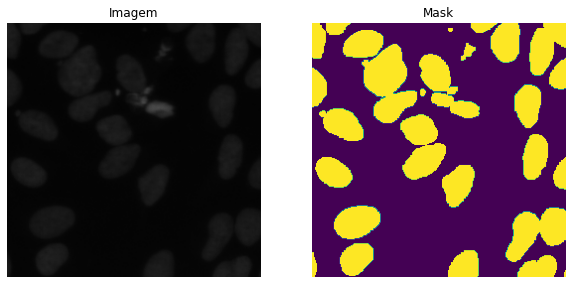

In [15]:
id_img = 0
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(dataset_img[id_img])
plt.axis('off')
plt.title("Imagem")
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(dataset_mask[id_img]))
plt.axis('off')
plt.title("Mask")

In [16]:
X_test = np.zeros((len(teste_ids), img_altura, img_largura, canais), dtype=np.uint8)
redim_test = []
print('Redimensionando imagens de teste') 
for n, id_ in tqdm(enumerate(teste_ids), total=len(teste_ids)):
    if "." in path:
        continue

    path = path_teste + id_
    img = cv2.imread(path + '/images/' + id_ + '.png')[:,:,:canais]
    redim_test.append([img.shape[0], img.shape[1]])
    img = cv2.resize(img, (img_altura, img_largura))
    X_test[n] = img

print('Ok!')
print(X_test.shape)

Redimensionando imagens de teste


100%|██████████| 65/65 [00:00<00:00, 178.48it/s]

Ok!
(65, 256, 256, 3)


In [17]:
# Treinamento, Validação, Teste
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(dataset_img, dataset_mask, test_size = 0.10, random_state = 42)

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [19]:
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow/
def bloco_conv(input, num_filters):
  x = Conv2D(num_filters, 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

In [23]:
def bloco_encoder(input, num_filters):
  x = bloco_conv(input, num_filters)
  p = MaxPool2D((2,2))(x)
  return x, p

In [24]:
def bloco_decoder(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
  x = Concatenate()([x, skip_features])
  x = bloco_conv(x, num_filters)
  return x

In [25]:
def modelo_unet(input_shape):
  inputs = Input(input_shape)
  s1, p1 = bloco_encoder(inputs, 64)
  s2, p2 = bloco_encoder(p1, 128)
  s3, p3 = bloco_encoder(p2, 256)
  s4, p4 = bloco_encoder(p3, 512)

  b1 = bloco_conv(p4, 1024)

  d1 = bloco_decoder(b1, s4, 512)
  d2 = bloco_decoder(d1, s3, 256)
  d3 = bloco_decoder(d2, s2, 128)
  d4 = bloco_decoder(d3, s1, 64)

  outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

  model = Model(inputs, outputs, name='UNet')
  return model

In [27]:
model = modelo_unet((img_altura, img_largura, canais))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                              

In [28]:
arquivo_modelo = 'modelo_unet.json'
modelo_json = model.to_json()
with open(arquivo_modelo, 'w') as json_file:
  json_file.write(modelo_json)

In [29]:
nome_modelo = 'modelo_unet.h5'
checkpointer = ModelCheckpoint(nome_modelo, verbose=1, save_best_only=True)
early_stopper = EarlyStopping(patience = 5, monitor='val_loss')
callbacks = [checkpointer, early_stopper]

In [30]:
epochs = 15
batch_size = 8

In [31]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/15
76/76 [==============================] - ETA: 0s - loss: 0.4384 - accuracy: 0.8589
Epoch 1: val_loss improved from inf to 0.45944, saving model to modelo_unet.h5
76/76 [==============================] - 46s 419ms/step - loss: 0.4384 - accuracy: 0.8589 - val_loss: 0.4594 - val_accuracy: 0.9073
Epoch 2/15
76/76 [==============================] - ETA: 0s - loss: 0.2335 - accuracy: 0.9553
Epoch 2: val_loss improved from 0.45944 to 0.28392, saving model to modelo_unet.h5
76/76 [==============================] - 27s 349ms/step - loss: 0.2335 - accuracy: 0.9553 - val_loss: 0.2839 - val_accuracy: 0.9349
Epoch 3/15
76/76 [==============================] - ETA: 0s - loss: 0.1861 - accuracy: 0.9642
Epoch 3: val_loss improved from 0.28392 to 0.18901, saving model to modelo_unet.h5
76/76 [==============================] - 27s 351ms/step - loss: 0.1861 - accuracy: 0.9642 - val_loss: 0.1890 - val_accuracy: 0.9501
Epoch 4/15
76/76 [==============================] - ETA: 0s - loss: 0.1605 - 

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
def plot_loss(history):
  fig = plt.gcf()
  fig.set_size_inches(16,4)
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], 'red', label='Accuracy Train')
  plt.plot(history.history['val_accuracy'], 'blue', label='Accuracy Validation')
  plt.legend()
  plt.title("Accuracy")

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], 'red', label='Loss Train')
  plt.plot(history.history['val_loss'], 'blue', label='Loss Validation')
  plt.legend()
  plt.title('Loss')
  plt.show()


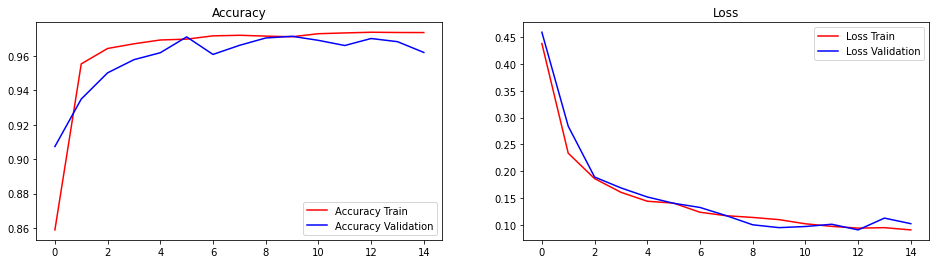

In [44]:
plot_loss(history)

In [45]:
predicoes_val = model.predict(X_val)

3/3 [==============================] - 10s 171ms/step


In [46]:
predicoes_val.shape # sigmoide

(67, 256, 256, 1)

In [47]:
predicoes_val[0].min(), predicoes_val[0].max()

(0.01745985, 1.0)

In [48]:
predicoes_val = (predicoes_val > 0.5).astype(np.uint8)
predicoes_val

array([[[[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [1]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [1],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [1],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [49]:
np.unique(predicoes_val[0], return_counts=True)

(array([0, 1], dtype=uint8), array([50953, 14583]))

In [50]:
def compara_segmentacoes(original, ground_truth, predicao):
  fig = plt.figure(figsize=(12, 7))

  fig.add_subplot(1,3,1) 
  plt.imshow(original)
  plt.axis("off")
  plt.title("Imagem Original")

  fig.add_subplot(1,3,2) 
  plt.imshow(ground_truth)
  plt.axis("off")
  plt.title("Máscara real (ground truth)")

  fig.add_subplot(1,3,3) 
  plt.imshow(predicao)
  plt.axis("off")
  plt.title("Predição")

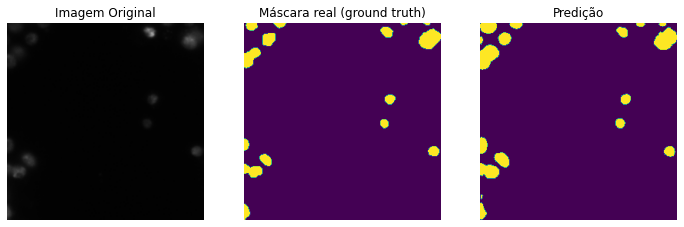

In [51]:
idx = 30
compara_segmentacoes(X_val[idx], np.squeeze(y_val[idx]), np.squeeze(predicoes_val[idx]))

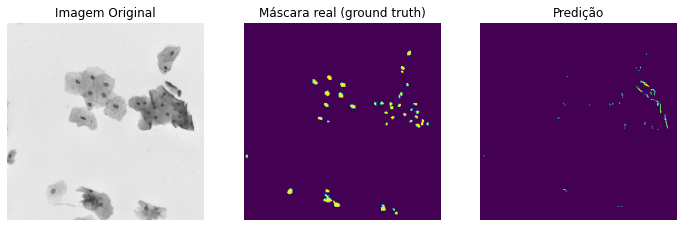

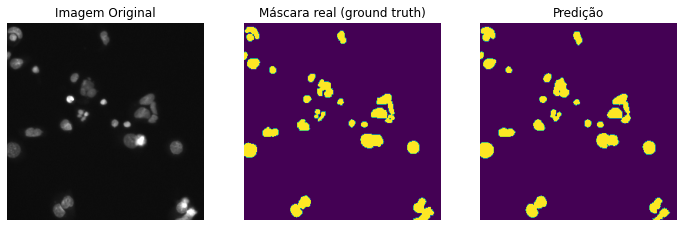

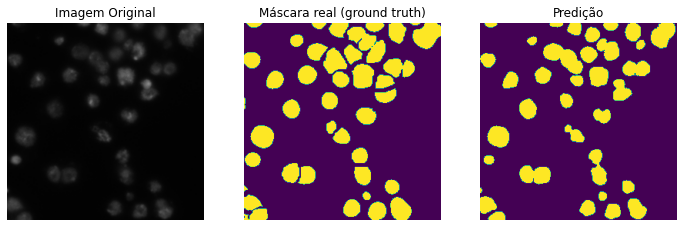

In [52]:
imgs_teste = np.random.choice(len(X_val), 3)
for img_id in imgs_teste:
  compara_segmentacoes(X_val[img_id], np.squeeze(y_val[img_id]), np.squeeze(predicoes_val[img_id]))
  

In [53]:
predicoes_teste = model.predict(X_test)
predicoes_teste = (predicoes_teste > 0.5).astype(np.uint8)

3/3 [==============================] - 2s 871ms/step


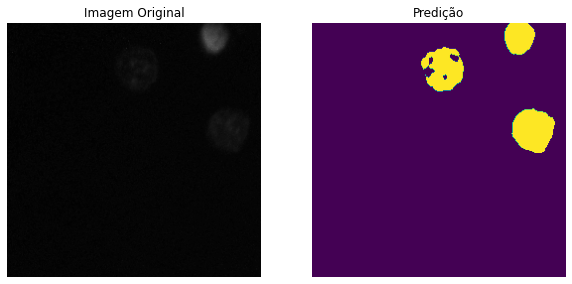

In [54]:
idx = random.randint(0, len(X_test))

fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1,2,1) 
plt.imshow(X_test[idx])
plt.axis("off")
plt.title("Imagem Original")

fig.add_subplot(1,2,2) 
plt.imshow(np.squeeze(predicoes_teste[idx]))
plt.axis("off")
plt.title("Predição");

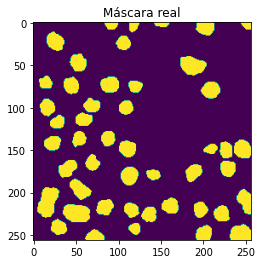

In [55]:
id_img_teste = 0
img_teste = X_val[id_img_teste]
ground_truth = y_val[id_img_teste]
plt.imshow(np.squeeze(ground_truth))
plt.title('Máscara real');

In [56]:
from tensorflow.keras.metrics import MeanIoU
iou_resultado = MeanIoU(num_classes = 2)